<a href="https://colab.research.google.com/github/yasmin-amaro/Data-Science/blob/main/An%C3%A1lise_de_sentimentos_empresa_de_TI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 3.7MB/s 


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import os
import pandas as pd
import re
import spacy
import numpy as np
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset
from sklearn.model_selection import KFold
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
from sklearn.metrics import matthews_corrcoef
from sklearn.base import TransformerMixin
from sklearn.preprocessing import FunctionTransformer

In [ ]:
# importando as bibliotecas necessárias para fazer plots com o Plotly
# O Cufflinks conecta o pandas ao Plotly:
!pip install cufflinks
!pip install plotly
#!pip install chart_studio

In [ ]:
import plotly
import plotly.offline as py

from plotly.offline import plot, iplot
plotly.offline.init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook_connected'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery']

In [ ]:
pio.renderers.default = "colab"

In [ ]:
!pip3 install -U textblob
!python3 -m textblob.download_corpora

Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
from textblob import TextBlob

In [ ]:
pip install wordcloud

In [ ]:
def clean_text(msg):
    msg = msg.lower() #transforma as letras em minúsculas
    msg = re.sub('[^a-zA-Z]', ' ', msg)   #a função sub, da biblioteca re, transforma todos os caracteres não alfabéticos em espaços
    msg = ' '.join(msg.split())  #a mensagem é fragmentada em uma lista de palavras utilizando a função split e depois são unidas de volta formando uma nova mensagem. O que essa linha de código faz é a remoção de espaços desnecessários
    return msg

#aplicação de um método de normalização que pode ser a stemming ou a lemmatization

def stemming(msg):
    msg = clean_text(msg)
    stemmer = SnowballStemmer(language='english') #o SnowballStemmer está disponível na biblioteca NLTK
    wordlist = [stemmer.stem(word) for word in msg.split() if word not in
                set(stopwords.words('english'))] # a mensagem é dividida em uma lista onde cada elemento é formado pelo radical (stem) de uma das palavras que compõem a mensagem. São também descartadas as palavras que estão na lista de stopwords na NLTK.
    msg = ' '.join(wordlist) # as palavras são novamente reunidas em uma mensagem usando o método join, sendo separadas por um espaço.
    return msg

def lemmatization(msg):
    msg = clean_text(msg)
    doc = nlp(msg) # A função nlp é uma variável que carrega a informação da função load (essa atribuição foi feita fora da função, e será mostrada mais à frente), que retorna uma série de informações referentes à mensagem
    tokenlist = [token.lemma_ for token in doc if str(token) not in
                 set(nlp.Defaults.stop_words)] # extrai-se o lemma de cada palavra da mensagem. Da mesma forma, descartam-se todas as palavras que sejam stopwords.
    msg = ' '.join(tokenlist)
    return msg

#construção de uma função que, dada uma lista de textos, retorna quais são suas palavras mais frequentes
# A lista de textos foi denominada wordlist , sendo n o número de palavras a serem retornadas. 
# As mensagens da lista são unidas em uma única mensagem (big_sen), e a função split transforma a mensagem em uma lista com as palavras que a compõe. Então, a função Counter juntamente com a função most_common, ambas da biblioteca collections, retornam uma lista apenas com as “n” palavras mais frequentes

def word_freq(wordlist, n):
    big_sen = ''

    for sen in wordlist:
        big_sen += sen

    return Counter(big_sen.split()).most_common(n)


In [ ]:
# Parameters part 1
norm = lemmatization  # stemming, lemmatization
stopwords_cond = True  # True, False

# Adding stopwords
nlp = spacy.load('en_core_web_sm')

if stopwords_cond:
    for word in nlp.Defaults.stop_words:
        lex = nlp.vocab[word]
        lex.is_stop = True

    stopwords.words('english').extend(['a', 'e', 'n', 's', 'm', 'o', 'br', 'ls',
                                       'www', 'com', 'fot', 'cs', 'hayasa', 'apollo'])

    nlp.Defaults.stop_words |= {'a', 'e', 'n', 's', 'm', 'o', 'br', 'ls', 'www',
                                'com', 'fot', 'cs', 'hayasa', 'apollo'}

In [ ]:
# Loading dataset
dataset = pd.read_excel('Dataset OneHot.xlsx')
labels_dataframe = dataset.iloc[:, 1:]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


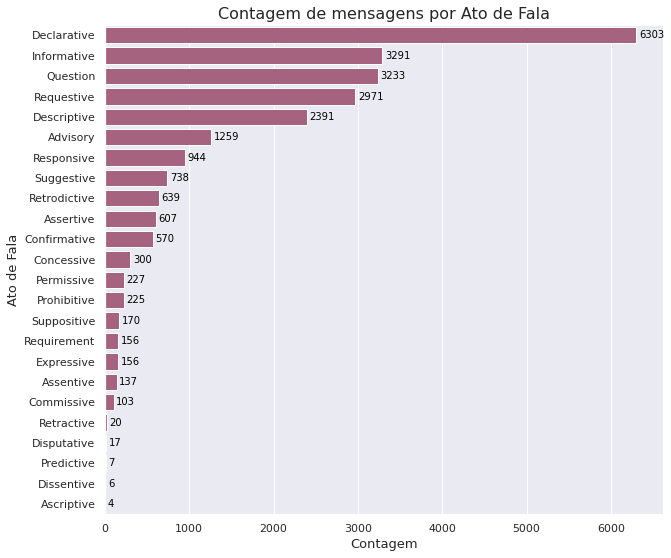

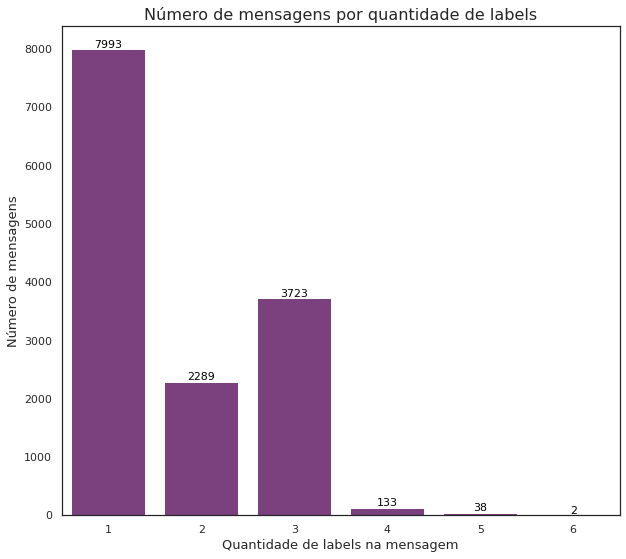

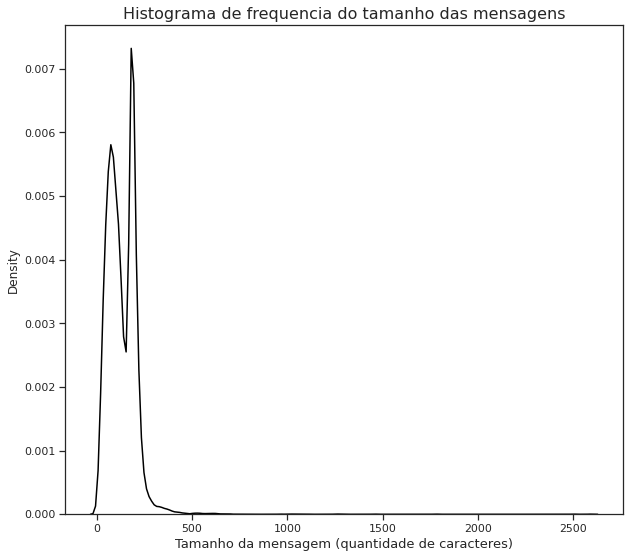

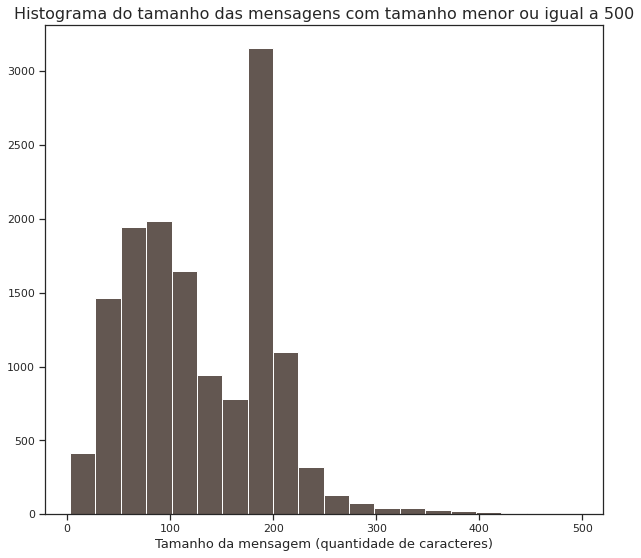

In [ ]:
# %%Visualizing classes
import seaborn as sns

sns.set()
sns.set_style('darkgrid')
plt.subplots(figsize=(10, 9))

sum_msgs = labels_dataframe.sum(axis=0).sort_values(ascending=False)

ax = sns.barplot(y=labels_dataframe.columns.values, x=sum_msgs, color='#B1587E')

for i, val in enumerate(sum_msgs):
    ax.text(val + 30, i, val, color='black', va='center', fontsize=10)

plt.ylabel('Ato de Fala', fontsize=13)
plt.xlabel('Contagem', fontsize=13)
plt.title('Contagem de mensagens por Ato de Fala', fontsize=16)

plt.savefig('cont msgs.png', dpi=300)

# %%Visualizing classes
sns.set_style('white')

count_lbl = (pd.DataFrame(labels_dataframe
                          .sum(axis=1)
                          .sort_values(ascending=False))
             .reset_index()
             .groupby(0).count()
             .reset_index()
             .rename(columns={0: 'num_lbl', 'index': 'count'}))

plt.subplots(figsize=(10, 9))
ax = sns.barplot(x=count_lbl['num_lbl'],
                 y=count_lbl['count'],
                 color='#833788')

for i, num_lbl, count in count_lbl.itertuples():
    ax.text(i, count + 30, count, color='black', ha='center', fontsize=11)

plt.xlabel('Quantidade de labels na mensagem', fontsize=13)
plt.ylabel('Número de mensagens', fontsize=13)
plt.title('Número de mensagens por quantidade de labels', fontsize=16)

# plt.savefig('count lbl.png', dpi=300)
# %%Visualizing classes
sns.set_style('ticks')

len_msgs = [len(msg) for msg in dataset['msgContent']]

plt.subplots(figsize=(10, 9))
sns.distplot(len_msgs, hist=False, color='black')
plt.xlabel('Tamanho da mensagem (quantidade de caracteres)', fontsize=13)
plt.title('Histograma de frequencia do tamanho das mensagens', fontsize=16)

plt.savefig('hist_freq.png', dpi=300)
# %%Visualizing classes

len_msgs = [len(msg) for msg in dataset['msgContent'] if len(msg) <= 500]

plt.subplots(figsize=(10, 9))
sns.distplot(len_msgs, bins=20, kde=False, hist_kws=dict(alpha=1), color='#635751')
plt.xlabel('Tamanho da mensagem (quantidade de caracteres)', fontsize=13)
plt.title('Histograma do tamanho das mensagens com tamanho menor ou igual a 500',
          fontsize=16)

plt.savefig('hist_tam_msgs.png', dpi=300)

In [ ]:
# %%Corpus creation
corpus = [norm(msg) for msg in list(dataset['msgContent'])]

# %%Parameters part 2
method = BinaryRelevance  # BinaryRelevance, LabelPowerset
classifier = LogisticRegression  # LogisticRegression, SVC, GaussianNB
max_iterations = 40
max_ft = 2000
k = 5


In [ ]:
# Criação de modelo e divisão do conjunto de dados
# Criação do modelo Bag of Words
# dada uma lista de frases, cria uma matriz onde as frases dessa lista são representadas nas linhas, 
# e onde cada palavra existente nesse conjunto de frases é representada nas colunas. As palavras não são duplicadas, 
# ou seja, existe apenas uma coluna para cada palavra, mesmo que ela apareça várias vezes na lista. Utiliza-se então 
# esta função no corpus e a matriz gerada é atribuída à variável X, cujas dimensões são de 14.178 linhas e 6.734 colunas 

cv = CountVectorizer(max_features=max_ft)
X = cv.fit_transform(corpus)
y = labels_dataframe.values #atribui-se à variável y a matriz de targets do dataset, ou seja, todas as colunas exceto a msgContent

acc_array = []
hamm_loss_array = []

kf = KFold(n_splits=k) #estabelece-se um número (k) de “folds”, e o conjunto dos dados de entrada para o aprendizado 
#é particionado em k subconjuntos

# Dividindo o conjunto de dados em treino e teste

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], \
                                       y[train_index], y[test_index]

    cf = method(classifier(max_iter=max_iterations, random_state=42)) #O random state, quando especificado, habilita a replicabilidade do modelo, ou seja, ao usar o mesmo número os resultados serão os mesmos
    cf.fit(X_train, y_train) #ainda em cada iteração foi utilizado o método fit da variável cf que realiza o ajuste do modelo baseado nos dados de treinamento
    y_pred = cf.predict(X_test) # Depois de realizar-se a predição das respostas do X_test, guardado na variável y_pred, compara-se estas respostas com as respostas reais y_test, com o objetivo de avaliar o desempenho do modelo de cada iteração. 

    acc_array.append(accuracy_score(y_test, y_pred))
    hamm_loss_array.append(hamming_loss(y_test, y_pred))

acc = np.mean(acc_array)
hamm_loss = np.mean(hamm_loss_array)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
my_msg = dataset.iloc[4562]['msgContent']
my_msg_clean = clean_text(my_msg)
my_msg_stem = stemming(my_msg)
my_msg_lemma =  lemmatization(my_msg)

wordlist = [word for word in my_msg_clean.split() if word not in 
            set(stopwords.words('english'))]

msg_stpwd = ' '.join(wordlist)

doc = nlp(msg_stpwd)
tokenlist = [token.lemma_ for token in doc]
msg_lem = ' '.join(tokenlist)
    
my_msg = list([my_msg])
my_X = cv.transform(my_msg)


my_pred = cf.predict(my_X)

my_pred = my_pred.todense()

In [ ]:
# Printing used parameters
print('\n\033[4mParameters:\033[0m\n')
print(f'Normalization: {norm.__name__}')
print(f'\nMethod: {method.__name__}')
print(f'Classifier: {classifier.__name__}')
print(f'Max iterations: {max_iterations}')
print(f'Max features: {max_ft}')
print(f'k: {k}')


Parameters:

Normalization: lemmatization

Method: BinaryRelevance
Classifier: LogisticRegression
Max iterations: 40
Max features: 2000
k: 5


In [ ]:
# Printing results
print('\n\033[4mMetrics:\033[0m\n')
print(f'Accuracy: {acc:.2%}')
print(f'Hamming Loss: {hamm_loss:.2%}')


Metrics:

Accuracy: 80.55%
Hamming Loss: 1.10%


ANÁLISE DE SENTIMENTO

In [ ]:
# Instalando a biblioteca vader que classifica sentimentos de frases

!pip install vaderSentiment

     |████████████████████████████████| 133kB 4.2MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer ()

In [ ]:
# Para ajustar o nº máximo de caracters que irão aparecer na coluna

pd.set_option('max_colwidth', 300)

In [ ]:
# escolhendo aleatoriamente algumas frases do dataset sem pré processamento e com o pré processamento realizado no
# trabalho da Paloma e do Victor
 
print(analyser.polarity_scores('You need someone to see the machine?'))
print(analyser.polarity_scores('need machine'))
print(analyser.polarity_scores('You need to check: - Ability to perform client backup  - All emails are in Webmail ?'))
print(analyser.polarity_scores('need check ability perform client backup email webmail'))
print(analyser.polarity_scores('You need to install a new hard drive'))
print(analyser.polarity_scores('need install new hard drive'))
print(analyser.polarity_scores('need install new drive'))

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'compound': 0.3182}
{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'compound': 0.3182}
{'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'compound': -0.1027}
{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.1027}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [ ]:
# analisando algumas frases para entender como funciona o Vader

print(analyser.polarity_scores('This is good'))
print(analyser.polarity_scores('This is good!!!'))
print(analyser.polarity_scores('This is very good'))
print(analyser.polarity_scores('This is very good!!!'))
print(analyser.polarity_scores('Is this good?'))
print(analyser.polarity_scores('This is not good'))
print(analyser.polarity_scores('This is very GOOD'))
print(analyser.polarity_scores('This is better'))
print(analyser.polarity_scores('This could be better'))
print(analyser.polarity_scores('The acting was good, but the film could have been better'))
print(analyser.polarity_scores('The acting was good, but the film is bad'))
print(analyser.polarity_scores('You are 10'))
print(analyser.polarity_scores('This is good :-))'))
print(analyser.polarity_scores('This is not good :-(('))

{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.346, 'pos': 0.654, 'compound': 0.5826}
{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.4927}
{'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'compound': 0.6211}
{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}
{'neg': 0.445, 'neu': 0.555, 'pos': 0.0, 'compound': -0.3412}
{'neg': 0.0, 'neu': 0.433, 'pos': 0.567, 'compound': 0.6028}
{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.608, 'pos': 0.392, 'compound': 0.7003}
{'neg': 0.347, 'neu': 0.511, 'pos': 0.142, 'compound': -0.5859}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.23, 'pos': 0.77, 'compound': 0.7717}
{'neg': 0.376, 'neu': 0.624, 'pos': 0.0, 'compound': -0.3412}


ANÁLISE SEM NENHUM PRÉ PROCESSAMENTO APLICADO

In [ ]:
# incluindo uma nova coluna no dataset com as pontuações via vader

dataset['scores'] = dataset['msgContent'].apply(lambda msgContent: analyser.polarity_scores(msgContent))

In [ ]:
#Incluindo uma coluna somente com a pontuação composta
dataset["compound"] = dataset["scores"].apply(lambda score_dict: score_dict ["compound"])

#Incluindo uma coluna de polaridade com a métrica sugerida no Vader
l_5 = []
def polaridade_5(arquivo):
  for i in arquivo["compound"]:
    if i>=0.05:
      l_5.append("pos")
    elif i<=-0.05:
      l_5.append("neg")
    else:
      l_5.append("neu")
  return l_5

dataset["polaridade_5"] = polaridade_5(dataset)

#Incluindo outras colunas de polaridade
l_10 = []
def polaridade_10(arquivo):
  for i in arquivo["compound"]:
    if i>=0.10:
      l_10.append("pos")
    elif i<=-0.10:
      l_10.append("neg")
    else:
      l_10.append("neu")
  return l_10

dataset["polaridade_10"] = polaridade_10(dataset)

l_0 = []
def polaridade_0(arquivo):
  for i in arquivo["compound"]:
    if i>0.00:
      l_0.append("pos")
    elif i<0.00:
      l_0.append("neg")
    else:
      l_0.append("neu")
  return l_0

dataset["polaridade_0"] = polaridade_0(dataset)

In [ ]:
# quantidade de frases por polaridade
pol_5 = dataset["polaridade_5"].value_counts()
pol_10 = dataset["polaridade_10"].value_counts()
pol_0 = dataset["polaridade_0"].value_counts()
#pol.plot.bar(color='green')


pol = pd.DataFrame(pol_5)
pol["polaridade_10"] = pol_10
pol["polaridade_0"] = pol_0

pol

,polaridade_5,polaridade_10,polaridade_0
pos,8714,8565,8771
neu,3548,3768,3365
neg,1916,1845,2042


In [ ]:
#sabendo a quantidade de palavras de cada frase
dataset['qt_palavras'] = dataset['msgContent'].apply(lambda x: len(str(x).split()))


In [ ]:
dataset['qt_palavras'].iplot ( 
    kind = 'hist', 
    bins = 100,
    linecolor = 'black',  
    title = 'comprimento do texto')

In [ ]:
#como visto no gráfico anterior, tem somente uma frase com mais de 600 palavras. 
#Para saber que frase é essa e suas caracteristicas:

tam_maior_frase = dataset['qt_palavras'].max()
for frase in dataset['msgContent']:
  if len(frase) == tam_maior_frase:
    print(frase)

maior_frase = list(filter(lambda x: len(x) == tam_maior_frase, dataset['msgContent']))

print(maior_frase)
print(tam_maior_frase)





[13:52:08] IT Naturativa - Luã Bastos: Tijuca. the machine that are with this problem. needs to close the right formula [13:52:24] IT Naturativa - Luã Bastos: ctrl + alt + del and ends the fcerta program [13:52:32] Store Manager Bar - Camila Rhymes: this error appears p we also [13:52:41] iT Naturativa - Luã Bastos: Wilson. I do not think it's some other application interfering in the process [13: 52:46] Wilson Oliveira: ok [13:53:20] iT Naturativa - Luã Bastos: the solution extends to all stations that are with the same problem [13:53:54] Luciana Jesus Commercial Assistant: I had the same error about 15 minutes ago but comes out and entered the Fcerta and is working.
["[13:52:08] IT Naturativa - Luã Bastos: Tijuca. the machine that are with this problem. needs to close the right formula [13:52:24] IT Naturativa - Luã Bastos: ctrl + alt + del and ends the fcerta program [13:52:32] Store Manager Bar - Camila Rhymes: this error appears p we also [13:52:41] iT Naturativa - Luã Bastos: Wil

In [ ]:
#o gráfico anterior ficou ruim de visualizar devido a algumas frases com um grande número de palavras
#portanto, para melhor visualização, é necessário plotar um gráfico em um intervalo que contenha a maior parte das frases
#nesse exemplo, frasses com no máx 100 palavras representam quase a totalidade do dataset
#criando uma lista com tamanhos de frases <= 100
def tam_palavras_100(dados):
  lista_pal100 = []
  for frase in dados:
    if len(frase)<=100:
      lista_pal100.append(len(frase))
  return lista_pal100

#transformando a lista em um DataFrame, uma vez que o iplot não aceita lista
df_pal100 = pd.DataFrame(tam_palavras_100(dataset['msgContent']))

df_pal100.iplot ( 
    kind = 'hist', 
    bins = 100,
    linecolor = 'black',  
    title = 'comprimento do texto')

In [ ]:
#polaridade das frases

dataset['compound'].iplot(kind='hist', bins=50, title='pontuação da polaridade')

In [ ]:
#plotando as 20 palavras mais frequentes

def top_n_palavras(corpus, n=None):
    vec = CountVectorizer().fit(corpus) #Converta uma coleção de documentos de texto em uma matriz de contagens de tokens
    bag_of_words = vec.transform(corpus)
    soma_palavras = bag_of_words.sum(axis=0) #axis=0 representa a linha
    freq_palavras = [(palavra, soma_palavras[0, idx]) for palavra, idx in vec.vocabulary_.items()]
    freq_palavras =sorted(freq_palavras, key = lambda x: x[1], reverse=True)
    return freq_palavras[:n]
palavras_comuns = top_n_palavras(dataset['msgContent'], 20)
for palavra, freq in palavras_comuns:
    print(palavra, freq)
df1 = pd.DataFrame(palavras_comuns, columns = ['msgContent' , 'count'])
df1.groupby('msgContent').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='20 palavras mais frequentes')

the 21793
in 9661
you 8179
to 7946
that 7712
request 5920
call 5223
your 5035
and 5002
be 4680
please 4315
was 4228
as 4010
is 3935
dear 3610
by 3235
advised 3132
not 3032
on 2816
registered 2798


In [ ]:
#plotando os 20 bigram mais frequentes

def top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range = ( 2 , 2 )).fit(corpus) #Converta uma coleção de documentos de texto em uma matriz de contagens de tokens
    #fit aprende um dicionário de vocabulário de todos os tokens nos documentos brutos, ou seja, cria um dicionário de tokens
    bag_of_words = vec.transform(corpus)
    soma_palavras = bag_of_words.sum(axis=0) #axis=0 representa a linha
    freq_palavras = [(palavra, soma_palavras[0, idx]) for palavra, idx in vec.vocabulary_.items()]
    freq_palavras =sorted(freq_palavras, key = lambda x: x[1], reverse=True)
    return freq_palavras[:n]
palavras_comuns = top_n_bigram(dataset['msgContent'], 20)
for palavra, freq in palavras_comuns:
    print(palavra, freq)
df2 = pd.DataFrame(palavras_comuns, columns = ['msgContent' , 'count'])
df2.groupby('msgContent').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='20 bigram mais frequentes')

in the 5263
the call 4668
your request 4571
that your 4489
advised that 3124
be advised 3123
please be 3087
registered in 2776
completed by 2430
great pleasure 2421
pleasure in 2415
in helping 2415
helping you 2415
was completed 2402
who took 2389
took great 2389
request registered 1934
by the 1706
at the 1677
is being 1604


In [ ]:
# distribuição das classes gramaticais usando a API TextBlob (Part-Of-Speech Tagging (POS))

blob = TextBlob(str(dataset['msgContent']))
pos_dataset = pd.DataFrame(blob.tags, columns = ['palavra' , 'pos'])
pos_dataset = pos_dataset.pos.value_counts()[:20]
pos_dataset.iplot(
    kind='bar',
    xTitle='POS', 
    title='Top 20 Part-of-speech tagging da lista de mensagens')
# NN = Noun 
# NNP = Proper Noun
# JJ = Adjective

In [ ]:
stemmer = PorterStemmer() #O objetivo da lematização é reduzir o número de formas flexionais de palavras que aparecem, isso fará com que palavras como “realizar” e “realizando” correspondam sintaticamente umas às outras. Isso ajuda a diminuir o tamanho do espaço do vocabulário e melhorar o volume do espaço do recurso no corpus.
pal = stopwords.words("english")
# remover a pontuação, os números e as stopwords. Transformar as letras em minusculas e usar o stemmer
dataset['msgProcessada'] = dataset['msgContent'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in pal]))

NameError: ignored

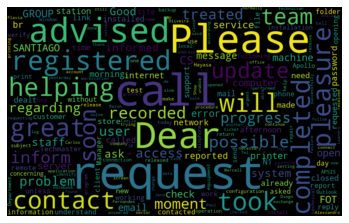

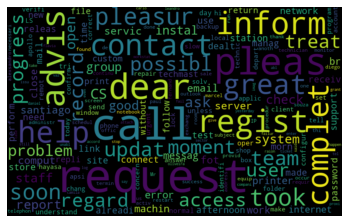

In [ ]:
#NÚVEM DE PALAVRAS SEM PRÉ PROCESSAMENTO

# para gerar uma imagem no próprio notebook
%matplotlib inline

# para fazer uma word cloud, temos que juntar todas as palavras em uma lista

todas_palavras = ' '.join([texto for texto in dataset.msgContent]) #' '.join vai juntar todas as frases por espaço
nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras) #esses parametros da wordcloud não determinam o tamanho da imagem, mas sim o tamanho de onde minhas palavras serão distribuídas. o parametro collocation=false traz a frequência de palavras (unigramas), o default é bigrama

#a variável nuvem_palavras é um objeto, agr tenho q tranformar esse objeto em uma figura:
plt.figure() #para determinar
plt.imshow(nuvem_palavras, interpolation='bilinear') #o parametro interpolation=bilinear deixa a resolução da imagem melhor
plt.axis("off") #tira os eixos da imagem
plt.show()

#NÚVEM DE PALAVRAS COM PRÉ PROCESSAMENTO

todas_palavras_proc = ' '.join([texto for texto in dataset.msgProcessada])
nuvem_palavras_proc = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras_proc)

plt.figure()
plt.imshow(nuvem_palavras_proc, interpolation='bilinear')
plt.axis("off")
plt.show()


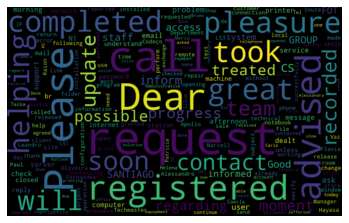

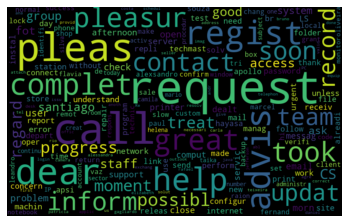

In [ ]:
#NUVEM DE PALAVRAS POSITIVAS SEM PRÉ PROCESSAMENTO

def nuvem_palavras_pos(texto, coluna_texto):
    texto_positivo = texto.query("polaridade_5 == 'pos'")
    todas_palavras = ' '.join([texto for texto in texto_positivo[coluna_texto]]) 
    nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras) 

    plt.figure() #para determinar
    plt.imshow(nuvem_palavras, interpolation='bilinear') #o parametro interpolation=bilinear deixa a resolução da imagem melhor
    plt.axis("off") #tira os eixos da imagem
    plt.show()

nuvem_palavras_pos(dataset, "msgContent")
nuvem_palavras_pos(dataset, "msgProcessada")

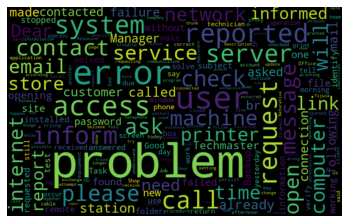

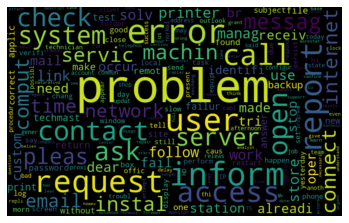

In [ ]:
def nuvem_palavras_neg(texto, coluna_texto):
    texto_positivo = texto.query("polaridade_5 == 'neg'")
    todas_palavras = ' '.join([texto for texto in texto_positivo[coluna_texto]]) 
    nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras) 

    plt.figure() #para determinar
    plt.imshow(nuvem_palavras, interpolation='bilinear') #o parametro interpolation=bilinear deixa a resolução da imagem melhor
    plt.axis("off") #tira os eixos da imagem
    plt.show()

nuvem_palavras_neg(dataset, "msgContent")
nuvem_palavras_neg(dataset, "msgProcessada")


In [ ]:
# cada corpus é transformado em modelo de espaço vetorial usando o vetorizador tf-idf no pacote SKlearn do Python
# LEMBRAR DE TESTAR OS PARAMETROS
# min_df ignora os termos que têm uma frequência de documento estritamente inferior ao limite fornecido
vetorizador = TfidfVectorizer(min_df= 1, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 1))
final_features = vetorizador.fit_transform(dataset['msgProcessada']).toarray()
final_features.shape

#há x features após converter o texto em vetores. Quando tem vetores muito longos, às vezes é melhor selecionar 
#as melhores features em vez de usar todas elas (é possível usar o método SelectKbest do pacote SKlearn.feature_selection)
#e pontuação de Chi2 que pode ser usada para selecionar os recursos n_features com os valores mais altos para o teste 
#qui-quadrado (mede a dependência entre as variáveis ​​estocásticas)

(14178, 5814)

In [ ]:
# dividindo os dados em treinamento e teste
X = dataset ['msgProcessada']
Y = dataset ['polaridade_5'] 
kf = KFold(n_splits=5)

# a função TfidfVectorizer produz uma matriz esparsa, e os modelos de classificação Naive Bayes e Random Forest Classifier
# requer uma matriz densa
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

for train_index, test_index in kf.split(X):
  X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.25, random_state=42)
  # pipeline (sequência de transformações): transformar o vetorizador tfidf, selecionar as K melhores características e
  # usar o classificador para ajustar os dados
  pipeline = Pipeline ([('vect', vetorizador), 
                     ('chi', SelectKBest (chi2, k = 2500)),
                     ('to_dense', DenseTransformer()),
                     ('clf', GaussianNB ())])
  
  model = pipeline.fit(X_train, Y_train) 
  Ytest = np.array(Y_test)
  Ypred = model.predict (X_test)

print (classification_report (Ytest, Ypred)) #mostra as principais métricas de classificação
print (confusion_matrix (Ytest, Ypred))
print ("MCC", matthews_corrcoef(Ytest, Ypred))

              precision    recall  f1-score   support

         neg       0.40      0.16      0.23       473
         neu       0.52      0.17      0.26       889
         pos       0.66      0.93      0.77      2183

    accuracy                           0.63      3545
   macro avg       0.53      0.42      0.42      3545
weighted avg       0.59      0.63      0.57      3545

[[  75   50  348]
 [  39  153  697]
 [  72   91 2020]]
MCC 0.20410260616608175


com pré processamento


In [ ]:
df_process = pd.DataFrame(corpus)
df_process = df_process.rename(columns={0: 'frase'})
df_process.head()

In [ ]:
dataset['frases_com_processamento'] = df_process['frase']
dataset['scores_com_processamento'] = df_process['frase'].apply(lambda frase: analyser.polarity_scores(frase))
dataset["neg_proc"] = dataset["scores_com_processamento"].apply(lambda score_dict: score_dict ["neg"])
dataset["neu_proc"] = dataset["scores_com_processamento"].apply(lambda score_dict: score_dict ["neu"])
dataset["pos_proc"] = dataset["scores_com_processamento"].apply(lambda score_dict: score_dict ["pos"])
dataset["compound_proc"] = dataset["scores_com_processamento"].apply(lambda score_dict: score_dict ["compound"])

#Incluindo uma coluna de polaridade com a métrica sugerida no Vader
l = []
def polaridade_5_proc(arquivo):
  for i in arquivo["compound_proc"]:
    if i>=0.05:
      l.append("pos")
    elif i<=-0.05:
      l.append("neg")
    else:
      l.append("neu")
  return l

dataset["polaridade_0.05_proc"] = polaridade_5_proc(dataset)

dataset.head()

In [ ]:
#definindo a quantidade de palavras de cada frase com pré processamento
dataset['qt_palavras_proc'] = dataset['frases_com_processamento'].apply(lambda x: len(str(x).split()))
dataset.head()

In [ ]:
dataset['qt_palavras_proc'].iplot ( 
    kind = 'hist', 
    bins = 100,
    linecolor = 'black',  
    title = 'comprimento do texto')

In [ ]:
#transformando a lista em um DataFrame, uma vez que o iplot não aceita lista
df_pal100_proc = pd.DataFrame(tam_palavras_100(dataset['frases_com_processamento']))

df_pal100_proc.iplot ( 
    kind = 'hist', 
    bins = 100,
    linecolor = 'black',  
    title = 'comprimento do texto')

In [ ]:
#polaridade das frases

dataset['compound_proc'].iplot(kind='hist', bins=50, title='pontuação da polaridade')

In [ ]:
palavras_comuns_proc = top_n_palavras(dataset['frases_com_processamento'], 20)
for palavra, freq in palavras_comuns_proc:
    print(palavra, freq)
df3 = pd.DataFrame(palavras_comuns_proc, columns = ['frases_com_processamento' , 'count'])
df3.groupby('frases_com_processamento').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='20 palavras mais frequentes')

request 6528
dear 3610
advise 3158
register 2806
help 2590
inform 2531
contact 2526
complete 2500
take 2479
great 2431
pleasure 2421
soon 1952
team 1805
update 1748
possible 1651
record 1650
treat 1531
access 1528
progress 1522
moment 1520


In [ ]:
palavras_comuns_proc = top_n_bigram(dataset['frases_com_processamento'], 20)
for palavra, freq in palavras_comuns_proc:
    print(palavra, freq)
df4 = pd.DataFrame(palavras_comuns_proc, columns = ['frases_com_processamento' , 'count'])
df4.groupby('frases_com_processamento').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='20 bigram mais frequentes')

advise request 3112
great pleasure 2421
pleasure help 2420
take great 2389
request register 1945
inform request 1592
record complete 1577
soon possible 1543
register treat 1501
contact soon 1500
moment contact 1499
treat moment 1498
possible update 1498
update progress 1498
team take 1370
staff take 855
register complete 847
complete team 800
complete staff 793
group santiago 730


In [ ]:
blob = TextBlob(str(dataset['frases_com_processamento']))
pos_dataset = pd.DataFrame(blob.tags, columns = ['palavra' , 'pos'])
pos_dataset = pos_dataset.pos.value_counts()[:20]
pos_dataset.iplot(
    kind='bar',
    xTitle='POS', 
    title='Top 20 Part-of-speech tagging da lista de mensagens')

In [ ]:
#word cloud
#histograma com qts palavras cada frase tem
#histograma por palavra com qts vezes ela aparece
#histograma com qts vezes a palavra apareceu em uma frase e no dataset todo
#grafo em q os nós sendo duas palavras mais frequentes e arestas com qts vezes ela aparece na msm frase
#as palavras que mais apareceram em frases positivas e palavras q mais apareceram em frases neg
#nlp visualization
#colocar a feature de polaridade como polaridade_0.05

#pegar as palavras mais frequentes somente com os adjetivos
# explorar os n-gramns na tokenização
# plotar as n frases mais longas (top 5)
# fazer um novo pre processamento
#precisa fazer o cross validation
#procurar cross validation fuction

#testar técnicas de treinamento, ex: arvore de decisão